# MLP-CW4 Experiment 5a 200x  execution notebook

This notebook is not for data exploration. But to log execution of experiments.

Experiment 5a
 - per magnification, augment data on rotation, horizontal, and vertical flip

In [1]:
import time 
for _ in range(160):
    time.sleep(60) 
print("Go!")

Go!


## Imports

In [2]:
# set the matplotlib backend so figures can be saved in the background
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import matplotlib
import keras
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2

import shutil
import fnmatch
import pickle
from keras import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.constraints import max_norm
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
import keras.initializers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import imgaug as ia
from imgaug import augmenters as iaa

/home/as12production/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Environment Settings

In [3]:
#Keras setting
K.set_image_dim_ordering('tf')  #Image dimension ordering

#Random seeds
SEED = 2082018
np.random.seed(SEED)

#Image Settings
IMAGE_RESIZE = (224,224)  # Image size. Process on the by data generator. Should match CNN model input. 
IMAGE_INPUT_SIZE = (224,224,3) #Image Input size to the neural network

#Training Settings
BATCH_SIZE = 32
EPOCH = 20

#Directories
# NOTE: The labels are determined by subfolders. PNG or JPEG images only.
TRAIN_DIR = '../TRAIN' 
VAL_DIR = '../VALID'
TEST_DIR =  '../TEST'


#["-40","-100-","-200-","-400-"]
magnifications = "-200-"
experiment_name = "experiment5a"

#Index of the class label represents numerical representation
CLASS_LABELS = ["Benign", "Malignant"]
NUM_CLASSES = 2
#Checkpoints and save files

#Saving every epochs that improve val accuracy
#MODEL_CHECKPOINT_FILE="baseline_model-weights-{epoch:02d}-{val_acc:.2f}.hdf5"
# Rewriting save file for epoch that improves val accuracy
MODEL_CHECKPOINT_FILE="inception3-weights.hdf5"  

#Training charts and graphics
MODEL_TRAIN_RESULTS_FILE="inception3_train.pickle"
MODEL_ACCURACY_GRAPH_FILE="inception3_accuracy.pdf"
MODEL_LOSS_GRAPH_FILE="inception3_loss.pdf"
MODEL_EVALUATION_CM_FILE="inception3_CM.pdf"

## Loading Dataset

In [4]:
def buildImageDataset(path, imageResize=None,shuffle=False,seed=0):
    """
    Load dataset into an array. Labels are defined by folder name.
    """
    filenames = []
    data = []
    labels = []
    imagePaths = sorted(list(paths.list_images(path)))
    
    if shuffle == True:
        random.seed(seed)
        random.shuffle(imagePaths)

    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        if imageResize != None:
            image = cv2.resize(image, imageResize)
        image = img_to_array(image)
        data.append(image)
        filenames.append(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        labels.append(CLASS_LABELS.index(label))
    return (np.array(data), np.array(labels), np.array(filenames))

def showClassDistribution(y, labels):
    figure = plt.figure(figsize=(10,5))
    ax = sns.countplot(x = y)
    ax.set_xticklabels(labels)
    plt.show()

In [5]:
run_this = 1

# Load and save
if run_this == 1:
    X_train, y_train, train_files = buildImageDataset(TRAIN_DIR,imageResize=IMAGE_RESIZE,seed=SEED)
    X_valid, y_valid, valid_files = buildImageDataset(VAL_DIR,imageResize=IMAGE_RESIZE,seed=SEED)   


In [6]:

run_this = 1

if run_this == 1:
    validDataFrame = pd.DataFrame({'label':y_valid, 'filename':valid_files})
    trainDataFrame = pd.DataFrame({'label':y_train, 'filename':train_files})
    
    index = [i for i,item in enumerate(trainDataFrame["filename"]) if magnifications in item]
    X_train = X_train[index]
    y_train = y_train[index]
    train_files = train_files[index]
    
    index = [i for i,item in enumerate(validDataFrame["filename"]) if magnifications in item]
    X_valid = X_valid[index]
    y_valid = y_valid[index]
    valid_files = valid_files[index]
    

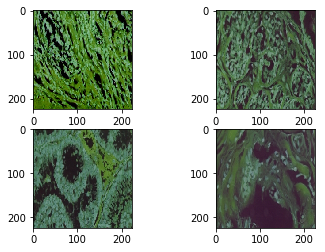

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X_train[-1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(X_train[1])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(X_valid[-1])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(X_valid[1])

fig.savefig("rescaled"+magnifications+"images.pdf")

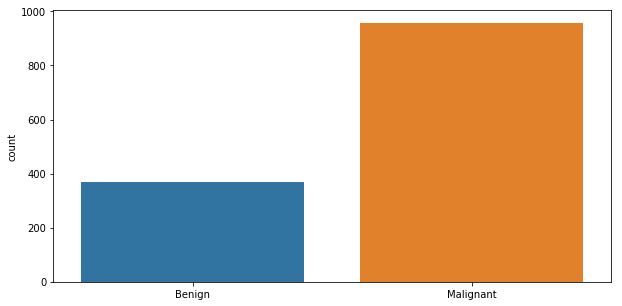

There are 1325 items in training set.


In [8]:
trainDataFrame = pd.DataFrame({'label':y_train, 'filename':train_files})
showClassDistribution(y_train, CLASS_LABELS)
print("There are {} items in training set.".format(len(y_train) ))

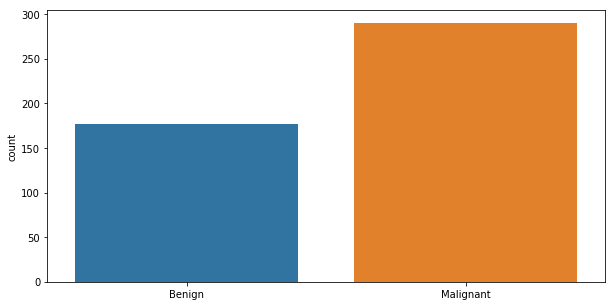

There are 467 items in validation set.


In [9]:
validDataFrame = pd.DataFrame({'label':y_valid, 'filename':valid_files})
showClassDistribution(y_valid, CLASS_LABELS)
print("There are {} items in validation set.".format(len(y_valid) ))

# Augmentation

In [10]:
run_this = 1

if run_this == 1:
    LR = iaa.Sequential([iaa.Fliplr(1)])
    UD = iaa.Sequential([iaa.Fliplr(1)])
    RT90 = iaa.Sequential([iaa.Affine(rotate=90)])
    RT180 = iaa.Sequential([iaa.Affine(rotate=180)])
    RT270 = iaa.Sequential([iaa.Affine(rotate=270)])
    images_aug1 = LR.augment_images(X_train)
    images_aug2 = UD.augment_images(X_train)
    images_aug3 = RT90.augment_images(X_train)
    images_aug4 = RT180.augment_images(X_train)
    images_aug5 = RT270.augment_images(X_train)
    X_train = np.vstack((np.vstack((
                     np.vstack((
                         np.vstack((
                             np.vstack((images_aug1,images_aug2)),images_aug3)),images_aug4)),images_aug5)),X_train))
    y_temp = np.array([])
    for i in range(6):
        y_temp = np.concatenate((y_temp,y_train))
    y_train = y_temp

## Pre-Processing


In [11]:
X_train /= 255.0
X_valid /= 255.0
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)

# Building Neural Net Model

In [12]:
# Building Models
def InceptionNet():
    #https://keras.io/applications/#inceptionv3
    #Use Inception 3 without the last layer.
    #Replace last layer with 1 sigmoid for binary classification
    sgd = SGD(lr=0.01, momentum=0.9,nesterov=False)
    model = keras.applications.inception_v3.InceptionV3(include_top=False,
                                                        weights='imagenet',  #Pre-train on ImageNet 
                                                        input_tensor=Input(shape=IMAGE_INPUT_SIZE),
                                                        input_shape=None,
                                                        pooling='avg',
                                                        classes=NUM_CLASSES)
    final = Model(input=model.input,output=Dense(NUM_CLASSES, activation='softmax')(model.output))
    final.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])    
    return final

# Required Function Definitions

In [13]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    plot = plt.figure()
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return plot

In [14]:
def generateTrainingPlots(history, accuracy_grap_file, loss_graph_file):
    plt.style.use('ggplot')
    accuracy_plot = plt.figure(figsize=(15,10))
    for k in ['val_acc', 'acc']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylim((0,1.2))
    plt.legend(['acc(valid)', 'acc(train)'], loc='upper left')
    plt.grid(True)
    plt.show()
    loss_plot = plt.figure(figsize=(15,10))
    for k in ['loss', 'val_loss']:
        data = np.array(history[k])
        plt.plot(data)
    plt.title('Model Loss')
    plt.ylabel('Error (Log Loss)')
    plt.xlabel('Epoch Number')
    plt.grid(True)
    plt.legend(['error(train)', 'error(valid)'], loc='upper left')
    plt.show()
    #Save visualization data    
    accuracy_plot.savefig(accuracy_grap_file, bbox_inches='tight')
    loss_plot.savefig(loss_graph_file, bbox_inches='tight')


In [15]:
def evaluateClassifier(history, classifier, weights, X ,y , cm_file, out_file, classlabels):
    classifier.load_weights(weights)
    y_pred = classifier.predict(X)
    cm = confusion_matrix(np.argmax(y,axis=1), np.argmax(np.rint(y_pred),axis=1))
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plot = plot_confusion_matrix(cm_norm, classes=classlabels)
    plot.savefig(cm_file, bbox_inches='tight')
    scores = classifier.evaluate(X_valid,y_valid)
    with open(out_file, 'w') as the_file:
        the_file.write("Max Val Acc: " + str(np.max(np.array(history['val_acc']))))
        the_file.write("\nMin Val Acc: " + str(np.min(np.array(history['val_acc']))))
        the_file.write("\nMax Train Acc: "  + str(np.max(np.array(history['acc']))))
        the_file.write("\nMin Train Acc: "  + str(np.min(np.array(history['acc']))))
        the_file.write("\nMax Val Err: "  + str(np.max(np.array(history['val_loss']))))
        the_file.write("\nMin Val Err: " + str(np.min(np.array(history['val_loss']))))
        the_file.write("\nMax Train Err: " + str(np.max(np.array(history['loss']))))
        the_file.write("\nMin Train Err: " +  str(np.min(np.array(history['loss']))))
        the_file.write("\nResult: " + str(scores))
        the_file.write("\nResult: " +  str(model.metrics_names))
        

# Training & Visualizing & Evaluating

In [16]:
for i in range(1,4):
    print("Running Experiment Iteration",i)
    model = InceptionNet()
    #Process filenames
    prefix = "run#{}_".format(i)
    MODEL_CHECKPOINT_FILE=prefix + experiment_name + magnifications+"inception3-weights.hdf5"  
    #Training charts and graphics
    MODEL_TRAIN_RESULTS_FILE=prefix + experiment_name + magnifications+"inception3_train.pickle"
    MODEL_ACCURACY_GRAPH_FILE=prefix + experiment_name + magnifications+"inception3_accuracy.pdf"
    MODEL_LOSS_GRAPH_FILE=prefix + experiment_name + magnifications+"inception3_loss.pdf"
    MODEL_EVALUATION_CM_FILE=prefix + experiment_name + magnifications+"inception3_CM.pdf"
    MODEL_EVALUATION_TEXT_FILE=prefix + experiment_name + magnifications+"inception3_eval.txt"
    
    checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    #Training
    history = model.fit(x=X_train,y=y_train,
                        validation_data=(X_valid,y_valid),
                        batch_size=BATCH_SIZE,
                        epochs = EPOCH,
                        callbacks = callbacks_list)
    
    #Saving training result
    with open(MODEL_TRAIN_RESULTS_FILE, "wb") as output_file:
        pickle.dump(history.history, output_file)    
    
    #Generate training graphs
    generateTrainingPlots(history.history, MODEL_ACCURACY_GRAPH_FILE, MODEL_LOSS_GRAPH_FILE)
    
    #evaluate classifier
    evaluateClassifier(history.history, InceptionNet(), MODEL_CHECKPOINT_FILE, 
                       X_valid ,y_valid , MODEL_EVALUATION_CM_FILE, MODEL_EVALUATION_TEXT_FILE, CLASS_LABELS)
    del model

Running Experiment Iteration 1


/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Train on 7950 samples, validate on 467 samples
Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[1,3,384,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/Variable_160/Assign = Assign[T=DT_FLOAT, _class=["loc:@training/SGD/Variable_160"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/Variable_160, training/SGD/zeros_158)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/SGD/Variable_160/Assign', defined at:
  File "/home/as12production/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/as12production/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-ec0e209cb1eb>", line 22, in <module>
    callbacks = callbacks_list)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1689, in fit
    self._make_train_function()
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 177, in get_updates
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 177, in <listcomp>
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 691, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 392, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 229, in __init__
    constraint=constraint)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 366, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 59, in assign
    use_locking=use_locking, name=name)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/as12production/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,3,384,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training/SGD/Variable_160/Assign = Assign[T=DT_FLOAT, _class=["loc:@training/SGD/Variable_160"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/SGD/Variable_160, training/SGD/zeros_158)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
print("Completed")

In [ ]:
%%javascript
Jupyter.notebook.session.delete();